In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
from scipy import sparse

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

import seaborn as sns

In [2]:
adata = sc.read_h5ad('../data/RREAE_5k_raw_integration_processed.h5ad')

In [6]:
list(adata.obs.celltype_merged.unique())

['Neuron',
 'T cell',
 'APC/Myeloid',
 'B cell',
 'Monocyte',
 'Endothelial',
 'Oligodendrocyte',
 'Fibroblast',
 'Astrocyte',
 'Ependymal',
 'Glial-like',
 'Foamy Myeloid',
 'Monocyte (inflammatory)',
 'Microglia',
 'Pericyte',
 'OPC',
 'Dendritic cell',
 'Mixed glia-vascular',
 'T cell (cycling)',
 'Fibroblast (cycling)',
 'Metabolic-like']

In [7]:
cells = [
 'T cell',
 'APC/Myeloid',
 'B cell',
 'Monocyte',
 'Foamy Myeloid',
 'Monocyte (inflammatory)',
 'Microglia',
 'Dendritic cell',
 'T cell (cycling)',
]

In [ ]:
adata_sub = adata[adata.obs.celltype_merged.isin(cells)]

In [19]:
GENESETS = {
    "Glycolysis": [
        "Hk1","Hk2","Gpi1","Pfkl","Pfkp","Aldoa","Aldoc","Tpi1",
        "Pgk1","Pgk2","Eno1","Eno2","Pkm","Ldha","Ldhb"
    ],
    "OXPHOS": [
        # Complex I–V (subset, after removal)
        "Ndufs1","Ndufv2",
        "Sdha","Sdhb",
        # removed Cyc1, Cox4i1, Cox5a, Cox6a1, Cox7a2, Uqcrc1, Uqcrc2, Atp5f1a, Atp5f1b, Atp5mc1, Atp5me
    ],
    "FAO": [
        "Cpt1a","Cpt2","Hadhb","Acox1"
        # removed Acadm, Acadl, Acadvl, Acox2
    ],
    "LactateTransport": ["Slc16a1","Slc16a3"],   # Mct1/Mct4
    "GlucoseTransport": ["Slc2a1","Slc2a3"],
    "Regulators_Hif1a_Myc": ["Hif1a","Myc","Pdk1"],  # removed Pfkfb3
    "MitoStress": [
        "Pink1","Park7","Hspa9","Hspd1",
        "Sod2","Atf4","Ddit3"
        # removed Gpx1, Txn2
    ],
}


In [48]:
adata

AnnData object with n_obs × n_vars = 891821 × 5101
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'grid_label', 'project', 'strain', 'n_genes_by_counts', 'n_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'sample_id', 'sub_type', 'cell_type', 'cell_class', 'area', 'sample_name', 'region', 'course', 'condition', 'model', 'cell_id', 'rbd_domain', 'sub_type_I', 'sub_type_II', 'sub_type_III', 'cell_id_2', 'match_key', 'lesion_density_call', 'lesion_distance_um', 'lesion_distance_bin', 'celltype_merged', 'dist_bin'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'cell_class_colors', 'cell_polygons', 'cell_type_colors', 'condition_colors', 'course_colors', 'd

categories: MOG CFA, PLP CFA, chronic long, etc.
var_group_labels: Glycolysis, OXPHOS, FAO, etc.


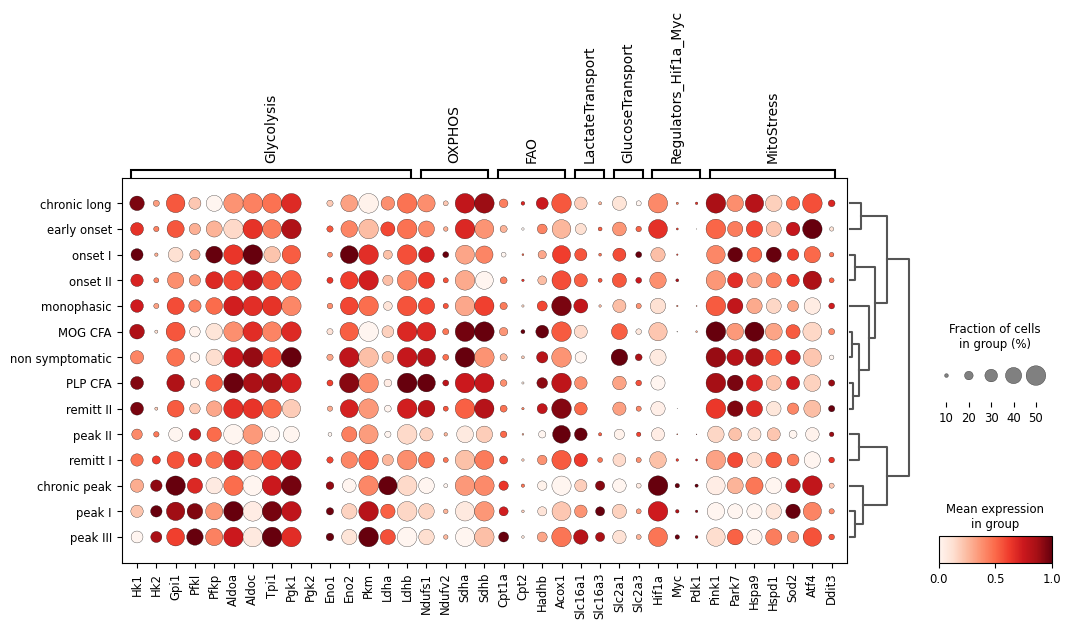

In [60]:

# Create dotplot (returns a dict of Figures when var_names is a dict)
sc.pl.dotplot(
    adata,
    var_names=GENESETS,
    groupby="course",
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.05,
    color_map="Reds",
    dendrogram=True,
 #  categories_order=ordered_cell_types,
    figsize=(12, 5),
)


In [61]:
immune_glia_factors = [
     "Tnf", "Gzmb",
         "Lta", "Ighm",
     "Ccl2", "Cxcl10", "Slc16a3",
        "Nos2", "Sod2", "Atf4", "Ddit3"
    ]

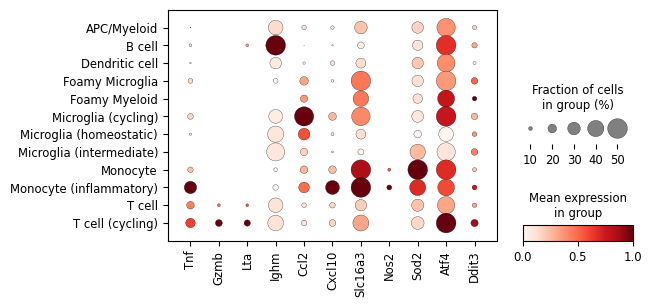

In [62]:

# Create dotplot (returns a dict of Figures when var_names is a dict)
sc.pl.dotplot(
    adata_sub[adata_sub.obs.course.isin(['peak I','peak II','peak III', 'chronic peak'])],
    var_names=immune_glia_factors,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
 #  categories_order=ordered_cell_types,
    figsize=(6, 3),
)


## Immune → Glia metabolic crosstalk (mouse genes)
- `Tnf` — Astrocytes → ↑ glycolysis; Oligodendrocytes → apoptosis, mitochondrial stress  
- `Gzmb` — Oligodendrocytes → granzyme-B–induced mitochondrial apoptosis
- `Lta` — Meningeal stromal/glial remodeling; sustains chronic inflammation  
- `Ighm` — Microglia → immune complex uptake, ↑ glycolysis & ROS
- `Ccl2` — Astrocytes → chemokine signaling; recruits monocytes; amplifies inflammation  
- `Cxcl10` — Astrocytes → pro-inflammatory activation; recruits T cells into CNS  
- `Slc16a3` — Lactate export (MCT4) → metabolic reprogramming of astrocytes, microglia, oligodendrocytes
- `Nos2` — NO release → inhibits mitochondrial respiration in oligodendrocytes & neurons  
- `Sod2` — Oxidative stress marker/mediator; excess ROS damages glia  
- `Atf4` — Stress-response TF; modulates astrocyte/oligodendrocyte metabolism  
- `Ddit3` — CHOP pathway → ER/mitochondrial stress; promotes apoptosis

In [90]:
mask = pd.Index(adata.var_names).str.contains(r"Nduf", case=False, na=False)
genes_matching = adata.var_names[mask].tolist()
genes_matching

['Ndufa12', 'Ndufa9', 'Ndufaf6', 'Ndufs1', 'Ndufs4', 'Ndufv2']

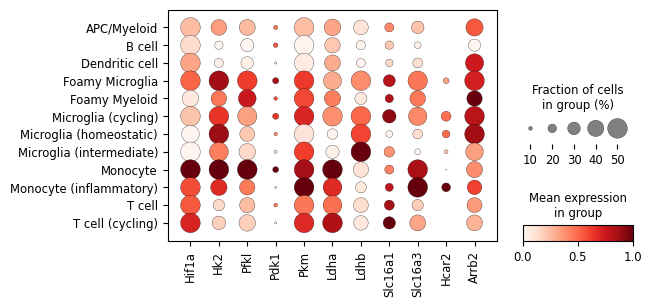

In [93]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Hcar2','Arrb2']

# Create dotplot (returns a dict of Figures when var_names is a dict)
sc.pl.dotplot(
    adata_sub[adata_sub.obs.course.isin(['peak I','peak II','peak III', 'chronic peak'])],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
 #  categories_order=ordered_cell_types,
    figsize=(6, 3),
)


In [ ]:

# Create dotplot (returns a dict of Figures when var_names is a dict)
sc.pl.dotplot(
    adata,
    var_names=GENESETS,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
 #  categories_order=ordered_cell_types,
    figsize=(15, 8),
)


In [96]:
adata.layers

Layers with keys: raw

In [110]:
adata.layers['transformed'] = adata.X.copy()

In [111]:
adata.X = adata.layers['raw'].copy()

In [ ]:
adata.X.toarray().max()

In [127]:
MODULES = {
    "Glycolysis_core": ["Hk2","Aldoa","Pkm","Pfkl","Pfkp","Eno1","Pgk1","Tpi1","Gpi1"],
    "Transporters":    ["Slc2a1","Slc2a3","Slc16a3","Slc16a1"],
    "Regulators":      ["Hif1a","Pik3cd","Akt1","Pdk1","Myc"],
}

# Flatten into a list (deduplicated)
flat_genes = sorted(set(sum(MODULES.values(), [])))
print(flat_genes)

['Akt1', 'Aldoa', 'Eno1', 'Gpi1', 'Hif1a', 'Hk2', 'Myc', 'Pdk1', 'Pfkl', 'Pfkp', 'Pgk1', 'Pik3cd', 'Pkm', 'Slc16a1', 'Slc16a3', 'Slc2a1', 'Slc2a3', 'Tpi1']


In [128]:
adata.X.toarray().max()

1401.0

In [132]:
sc.tl.score_genes(
    adata,
    gene_list=flat_genes,
    ctrl_size=50,
    use_raw=False,     # use adata.X (set layer below if desired)
    score_name="Glycolysis_score"
)

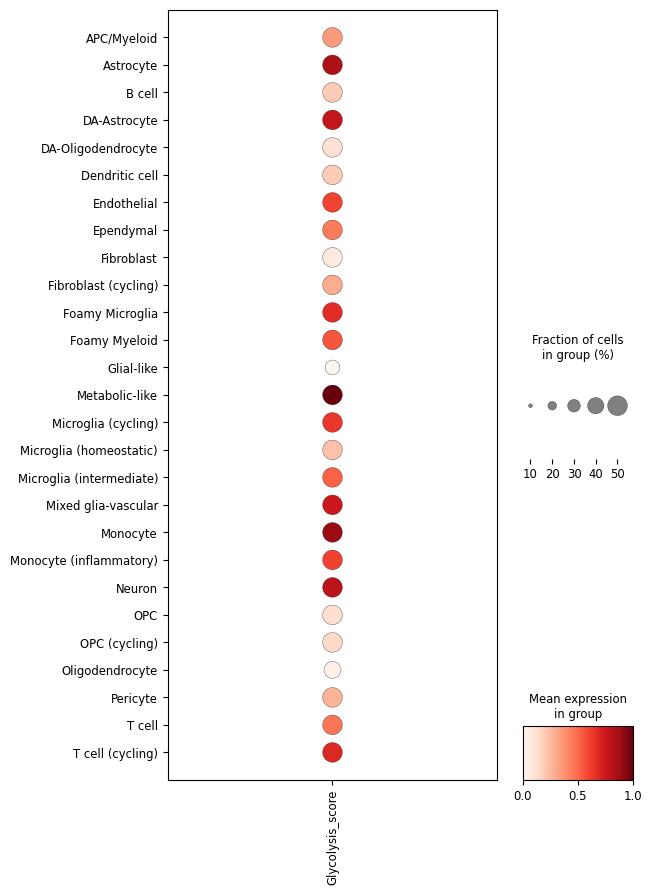

In [135]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Hcar2','Arrb2']

# Create dotplot (returns a dict of Figures when var_names is a dict)
sc.pl.dotplot(
    adata[adata.obs.course.isin(['peak I','peak II','peak III', 'chronic peak'])],
    var_names='Glycolysis_score',
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
 #  categories_order=ordered_cell_types,
    figsize=(6, 10),
)
